In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from time import perf_counter
import warnings

warnings.filterwarnings("ignore")

In [ ]:
class Evolutionary_Algorithm:
    __slots__ = [
        "mutation_rate",
        "crossover_rate",
        "number_of_generations",
        "population_size",
        "function_to_optimize",
        "population",
        "problem_dim",
        "hall_of_fame",
    ]

    def __init__(
        self,
        mutation_rate=0.7,
        crossover_rate=0.7,
        number_of_generations=50,
        population_size=100,
    ):
        self.population_size = population_size
        self.number_of_generations = number_of_generations
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.function_to_optimize = None
        self.population = None
        self.problem_dim = None
        self.hall_of_fame = []

    def _generate_population(self, n_genes):
        pass

    def _mutation(self, individual):
        pass

    def _crossover(self, parent1, parent2):
        pass

    def _evaluate_population(self):
        pass

    def _tournament_selection(self, fitness):
        probabilities = fitness / np.sum(fitness)
        return self.population[
            np.random.choice(
                range(len(self.population)),
                p=probabilities,
                size=self.population_size - len(self.hall_of_fame[-1]),
                replace=True,
            )
        ]

    def _select_individual(self, n=1):
        return self.population[
            np.random.choice(range(self.population_size), size=n, replace=False)
        ]

    def _visualize_individual(self, individual):
        print(individual)

    def optimize(self, function_to_optimize, silent=False):
        # initialize the population
        self.function_to_optimize = function_to_optimize
        self.problem_dim = function_to_optimize.__code__.co_argcount
        self._generate_population(self.problem_dim)
        best_evaluation_in_iteration = []
        best_solution_in_iteration = []

        # main algorithm loop
        for generation in range(self.number_of_generations):

            # crossover
            children = np.zeros(
                (2 * len(range(0, self.population_size, 2)), self.problem_dim)
            )
            for i in range(0, self.population_size, 2):
                parent1, parent2 = self._select_individual(n=2)
                children[i], children[i + 1] = self._crossover(parent1, parent2)
            self.population = np.vstack([self.population, children])

            # mutation
            # we mutate every individual in the population not random one
            mutated = np.zeros((self.population_size, self.problem_dim))
            for i in range(self.population_size):
                individual = self._select_individual()
                mutated[i] = self._mutation(individual)
            self.population = np.vstack([self.population, mutated])

            # evaluate the population and log the best solution
            fitness = self._evaluate_population()
            if not silent:
                print(
                    f"iter: {generation}, best: {np.min(fitness)} for {['%.3f' % n for n in self.population[self.hall_of_fame[-1][0]]]}"
                )

            best_evaluation_in_iteration.append(np.min(fitness))
            best_solution_in_iteration.append(self.population[self.hall_of_fame[-1][0]])

            # create new population
            self.population = np.vstack(
                [
                    self.population[self.hall_of_fame[-1]],
                    self._tournament_selection(fitness),
                ]
            )

        return best_evaluation_in_iteration, best_solution_in_iteration

In [353]:
def visualize_problem(size, rectangles, name, scaling_factor=2):
    fig, ax = plt.subplots()
    ax.set_aspect("equal")
    ax.set_xlim([0, 2.2 * size])
    ax.set_ylim([0, 2.2 * size])
    # here i want all axis and borders to be gray
    ax.spines["bottom"].set_color("gray")
    ax.spines["top"].set_color("gray")
    ax.spines["right"].set_color("gray")
    ax.spines["left"].set_color("gray")
    ax.xaxis.label.set_color("gray")
    ax.yaxis.label.set_color("gray")
    ax.tick_params(axis="x", colors="gray")
    ax.tick_params(axis="y", colors="gray")

    ax.set_title("Object to cut from")
    ax.add_patch(
        plt.Circle((size * 1.1, size * 1.1), size, fill=True, color="lightblue")
    )

    print(np.array(ax.get_position()).flatten())

    ax2 = fig.add_axes(
        [
            0.82125,
            0.11,
            0.82125 - 0.22375,
            0.88 - 0.11,
        ]
    )
    ax2.set_xlim([0, 2.2 * size])
    ax2.set_ylim([0, 2.2 * size])
    # remove axis from the second plot
    ax2.axis("off")

    ax2.set_title("    Rectangles", loc="left")
    df_hight = 300
    for rectangle in rectangles:
        x = 100
        y = df_hight
        df_hight = df_hight + rectangle[1] * scaling_factor
        ax2.add_patch(
            plt.Rectangle(
                (x, y),
                rectangle[0],
                rectangle[1],
                fill=True,
                color="pink",
                # add black edge to the rectangle
                edgecolor="black",
            )
        )
        ax2.add_patch(
            plt.Rectangle(
                (x, y),
                rectangle[0],
                rectangle[1],
                fill=False,
                color="black",
            )
        )

    # give title to the figure
    fig.suptitle(
        f"       Visualization of {name} cutting problem ", fontsize=20, y=1.03
    )
    plt.show()

In [343]:
r800 = pd.read_csv("./../data/genetics/r800.csv", header=None).values
r800

array([[250, 120, 100],
       [320, 160, 500],
       [250, 160, 600],
       [150, 120,  40],
       [400,  30, 400]])

[0.22375 0.11    0.80125 0.88   ]


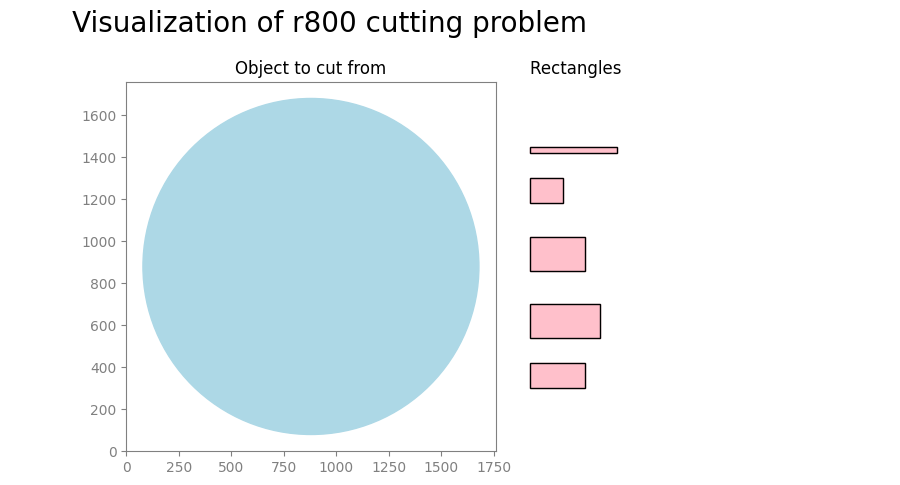

In [344]:
visualize_problem(800, r800, "r800")

In [345]:
r850 = pd.read_csv("./../data/genetics/r850.csv", header=None).values

[0.22375 0.11    0.80125 0.88   ]


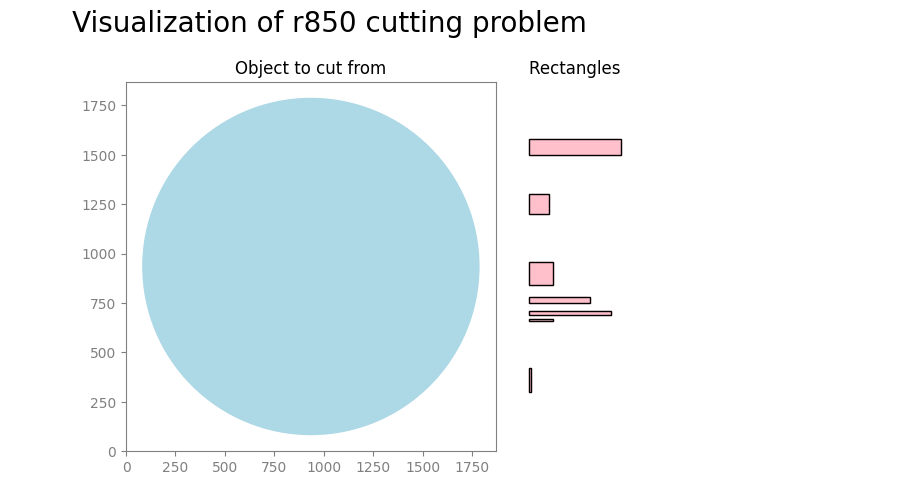

In [354]:
visualize_problem(850, r850, "r850", scaling_factor=3)